In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from IPython.display import display
import subprocess
import matplotlib

In [2]:
r1_without_intensity = pd.read_csv("/Users/gmortuza/PycharmProjects/dissertation/plot_generator/intensity_graph_generator/data/r1_without_intensity_ior.csv")
r2_without_intensity = pd.read_csv("/Users/gmortuza/PycharmProjects/dissertation/plot_generator/intensity_graph_generator/data/r2_without_intensity_ior.csv")
r3_without_intensity = pd.read_csv("/Users/gmortuza/PycharmProjects/dissertation/plot_generator/intensity_graph_generator/data/r3_without_intensity_ior.csv")

r1_with_intensity = pd.read_csv("/Users/gmortuza/PycharmProjects/dissertation/plot_generator/intensity_graph_generator/data/r1_with_intensity_ior.csv")
r2_with_intensity = pd.read_csv("/Users/gmortuza/PycharmProjects/dissertation/plot_generator/intensity_graph_generator/data/r2_with_intensity_ior.csv")
r3_with_intensity = pd.read_csv("/Users/gmortuza/PycharmProjects/dissertation/plot_generator/intensity_graph_generator/data/r3_with_intensity_ior.csv")


# data = data.loc[data.error >= 1]
r1_without_intensity.columns = r1_without_intensity.columns.str.strip().str.lower().str.replace(' ', '_')
r2_without_intensity.columns = r2_without_intensity.columns.str.strip().str.lower().str.replace(' ', '_')
r3_without_intensity.columns = r3_without_intensity.columns.str.strip().str.lower().str.replace(' ', '_')

r1_with_intensity.columns = r1_with_intensity.columns.str.strip().str.lower().str.replace(' ', '_')
r2_with_intensity.columns = r2_with_intensity.columns.str.strip().str.lower().str.replace(' ', '_')
r3_with_intensity.columns = r3_with_intensity.columns.str.strip().str.lower().str.replace(' ', '_')

In [3]:
# Generating error list table
def format_data(data):
    result_details = np.zeros((15, 4)) # First one will be correct second one incorrect
    orientation_details = np.zeros((4)).astype(int)
    error_details = np.zeros((data['error'].max()+1)).astype(int)
    error_locations_details = []
    #single_origami_error_locations_details = dict.fromkeys(list(range(15)),{'data':None, 'error_details':[], 'orientation':{0:0,1:0,2:0,3:0}})
    single_origami_error_locations_details = {}

    # Calculate number of one in a specific position
    number_of_one = np.zeros((6,8)).astype(int)
    error_mirror_x = {}
    error_mirror_y = {}
    for i in zip(range(6), reversed(range(6))):
        error_mirror_x[str(i[0])] = str(i[1])
    for i in zip(range(8), reversed(range(8))):
        error_mirror_y[str(i[0])] = str(i[1])

    for i, single_origami_result in data.iterrows():
        # Counting orientation
        if single_origami_result.decoded_index > 14:
            continue
        if single_origami_result.status == 1:
            # it's correct origami
            result_details[single_origami_result.decoded_index][0] += 1
            result_details[single_origami_result.decoded_index][3] += single_origami_result.error
            error_details[single_origami_result.error] += 1

            orientation_details[single_origami_result.orientation] += 1

            origami = np.array(list(single_origami_result.decoded_origami)).astype(int).reshape(6,8)
            number_of_one = np.add(number_of_one, origami)

            # Analyzing single origami.
            # set data
            if not single_origami_result.decoded_index in single_origami_error_locations_details:
                single_origami_error_locations_details[single_origami_result.decoded_index] = \
                {'data':single_origami_result.decoded_origami, 'error_details':[], 'orientation':{0:0,1:0,2:0,3:0},
                'correct':0}
            # Setting the orientation
            single_origami_error_locations_details[single_origami_result.decoded_index]\
            ['orientation'][single_origami_result.orientation] += 1
            single_origami_error_locations_details[single_origami_result.decoded_index]\
            ['correct'] += 1
            error_location = ""
            if single_origami_result.error > 0:
                single_origami_error = (single_origami_result.error_location).replace("(","").replace(")","").replace("[","").replace("]","").replace(" ","")
                for i in range(0, len(single_origami_error), 2):
                    # if the origami is mirror then mirror the error location:
                    if single_origami_result.orientation == 3:
                        error_location = error_mirror_x[single_origami_error[i]]+error_mirror_y[single_origami_error[i+1]]
                    else:
                        error_location = single_origami_error[i:i+2]
                    single_origami_error_locations_details[single_origami_result.decoded_index]\
            ['error_details'].append(error_location)


        else:
            result_details[single_origami_result.decoded_index][1] += 1

        result_details[single_origami_result.decoded_index][2] += 1

    # Analyzing error location
    error_occurance_list = Counter(error_locations_details).most_common()
    error_occurance = np.zeros((6, 8))
    for error in error_occurance_list:
        error_occurance[int(error[0][0])][int(error[0][1])] = error[1]
        
    result_sum = np.sum(result_details, axis=0).reshape(1, 4)
    result_details = np.append(result_details, result_sum, axis=0)

    # set the average error recovered per index
    for row in result_details:
        row[3] = float(row[3]) / float(row[0])

    x = np.array(np.arange(16)).reshape(16, 1)
    result_details = np.append(x, result_details, axis=1)
    result_details_df = pd.DataFrame(result_details, columns=['Recovered Index','Correct', 'Incorrect', 'Total',"Average error fixed"])
    result_details_df['Recovered Index'] = result_details_df['Recovered Index'].astype(int)
    result_details_df['Correct'] = result_details_df['Correct'].astype(int)
    result_details_df['Incorrect'] = result_details_df['Incorrect'].astype(int)
    result_details_df['Total'] = result_details_df['Total'].astype(int)
    result_details_df['Recovered Index'][15] = "Total"
    result_details_df.set_index('Recovered Index', inplace=True)
    
    return result_details_df, error_details, orientation_details, single_origami_error_locations_details, number_of_one

# single_origami_error_locations_details[1]["data"] = 10

In [4]:
r1_without_intensity_result, r1_without_intensity_error_details, r1_without_intensity_orientation, r1_without_intensity_single_origami_error_locations_details, r1_without_intensity_number_of_one = format_data(r1_without_intensity)
r2_without_intensity_result, r2_without_intensity_error_details, r2_without_intensity_orientation, r2_without_intensity_single_origami_error_locations_details, r2_without_intensity_number_of_one = format_data(r2_without_intensity)
r3_without_intensity_result, r3_without_intensity_error_details, r3_without_intensity_orientation, r3_without_intensity_single_origami_error_locations_details, r3_without_intensity_number_of_one = format_data(r3_without_intensity)

r1_with_intensity_result, r1_with_intensity_error_details, r1_with_intensity_orientation, r1_with_intensity_single_origami_error_locations_details, r1_with_intensity_number_of_one = format_data(r1_with_intensity)
r2_with_intensity_result, r2_with_intensity_error_details, r2_with_intensity_orientation, r2_with_intensity_single_origami_error_locations_details, r2_with_intensity_number_of_one = format_data(r2_with_intensity)
r3_with_intensity_result, r3_with_intensity_error_details, r3_with_intensity_orientation, r3_with_intensity_single_origami_error_locations_details, r3_with_intensity_number_of_one = format_data(r3_with_intensity)

# result_details_df.head(1000)

/var/folders/yz/7sx9j80n33x4tz7j6yr7tg0m0000gp/T/ipykernel_25030/462485147.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_details_df['Recovered Index'][15] = "Total"
/var/folders/yz/7sx9j80n33x4tz7j6yr7tg0m0000gp/T/ipykernel_25030/462485147.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_details_df['Recovered Index'][15] = "Total"
/var/folders/yz/7sx9j80n33x4tz7j6yr7tg0m0000gp/T/ipykernel_25030/462485147.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [5]:
bar_correct = pd.DataFrame([r1_without_intensity_result["Correct"].tolist(), r2_without_intensity_result["Correct"].tolist(), r3_without_intensity_result["Correct"].tolist()])
bar_fixed = pd.DataFrame([r1_without_intensity_result["Average error fixed"].tolist(), r2_without_intensity_result["Average error fixed"].tolist(), r3_without_intensity_result["Average error fixed"].tolist()])

In [6]:
bar_correct.sum()

0       96
1      112
2       19
3       32
4       46
5      123
6      141
7       23
8       60
9       55
10     105
11      65
12      54
13      93
14      96
15    1120
dtype: int64

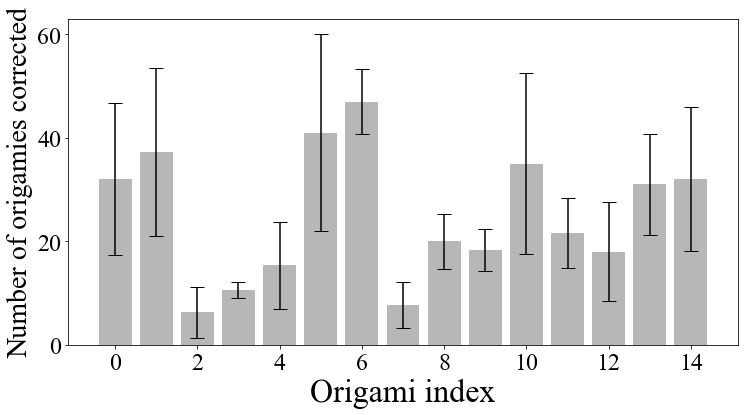

In [7]:
matplotlib.rc('figure', figsize=(12, 6))
plt.rcParams['font.size'] = 24
plt.rcParams["font.family"] = "Times New Roman"
# fig = plt.figure(figsize=(15, 10))
plt.bar(r1_without_intensity_result.index.to_numpy()[:15], bar_correct.mean().tolist()[:15], yerr=bar_correct.std().tolist()[:15], color='#b7b7b7', align='center', label="Without intensity", capsize=7)
# plt.bar(r1_without_intensity_result.index.to_numpy()[:15], r2_with_intensity_result["Correct"].tolist()[:15], color='#000', width=width, align='edge', label="With intensity")
plt.xlabel("Origami index", fontsize=32)
plt.ylabel("Number of origamies corrected", fontsize=28)
plt.savefig("dnam_wetlab_origami_detection_frequency.png", dpi=100, bbox_inches="tight")
# plt.legend()
plt.show()

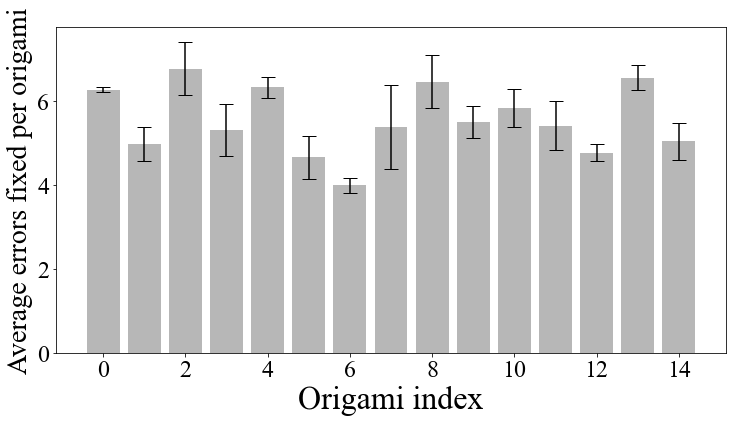

In [8]:
matplotlib.rc('figure', figsize=(12, 6))
plt.rcParams['font.size'] = 24
plt.rcParams["font.family"] = "Times New Roman"
# fig = plt.figure(figsize=(15, 10))
plt.bar(r1_without_intensity_result.index.to_numpy()[:15], bar_fixed.mean().tolist()[:15], yerr=bar_fixed.std().tolist()[:15], color='#b7b7b7', align='center', label="Without intensity", capsize=7)
# plt.bar(r1_without_intensity_result.index.to_numpy()[:15], r2_with_intensity_result["Correct"].tolist()[:15], color='#000', width=width, align='edge', label="With intensity")
plt.xlabel("Origami index", fontsize=32)
plt.ylabel("Average errors fixed per origami", fontsize=28)
plt.savefig("dnam_wetlab_origami_average_error_fixed.png", dpi=100, bbox_inches="tight")
# plt.legend()
plt.show()

In [9]:
# combine number of recovered origami from all cells
import operator
total_recovered_origami_without = list(map(operator.add, list(map(operator.add, r1_without_intensity_result["Correct"].tolist(), r2_without_intensity_result["Correct"].tolist())), r3_without_intensity_result["Correct"].tolist()))
total_recovered_origami_with = list(map(operator.add, list(map(operator.add, r1_with_intensity_result["Correct"].tolist(), r2_with_intensity_result["Correct"].tolist())), r3_with_intensity_result["Correct"].tolist()))

In [10]:
with_intensity_bar_correct = pd.DataFrame([r1_with_intensity_result["Correct"].tolist(), r2_with_intensity_result["Correct"].tolist(), r3_with_intensity_result["Correct"].tolist()])
with_intensity_bar_fixed = pd.DataFrame([r1_with_intensity_result["Average error fixed"].tolist(), r2_with_intensity_result["Average error fixed"].tolist(), r3_with_intensity_result["Average error fixed"].tolist()])



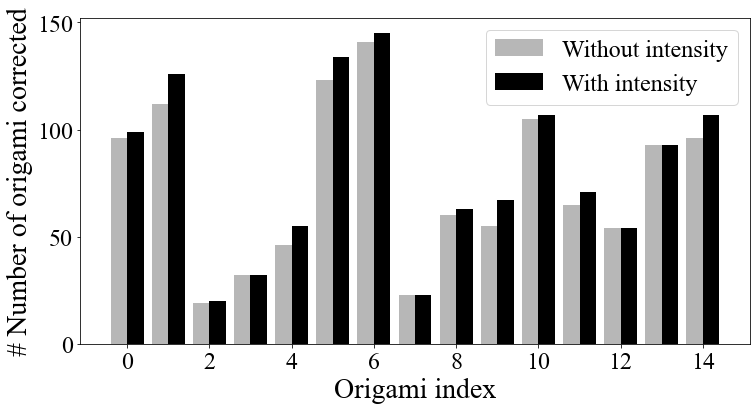

In [11]:
matplotlib.rc('figure', figsize=(12, 6))
plt.rcParams['font.size'] = 24
plt.rcParams["font.family"] = "Times New Roman"
# fig = plt.figure(figsize=(15, 10))
width=.4
plt.bar(r1_without_intensity_result.index.to_numpy()[:15] - .4, bar_correct.sum().tolist()[:15], color='#b7b7b7', width=width, align='edge', label="Without intensity")
plt.bar(r1_without_intensity_result.index.to_numpy()[:15], with_intensity_bar_correct.sum().tolist()[:15], color='#000', width=width, align='edge', label="With intensity")
plt.xlabel("Origami index", fontsize=28)
plt.ylabel("# Number of origami corrected", fontsize=28)
plt.legend()
plt.savefig("intensity_with_without_frequency.png", dpi=100, bbox_inches="tight", transparent=True, )
plt.show()
# result_details_df["Correct"].tolist()
# result_details_df.index

In [12]:
 # Orientation
result_orientation_df = pd.DataFrame(np.append([["Total"]], r1_without_intensity_orientation.reshape(1, 4), axis=1), columns=["","Unflipped","Flipped horizontally", "Flipped vertically", "Flipped horizontally and vertically"])
result_orientation_df.set_index("", inplace=True)
result_orientation_df.head()

,Unflipped,Flipped horizontally,Flipped vertically,Flipped horizontally and vertically
,,,,
Total,168,0,0,136


In [13]:
# Error details
error_df = pd.DataFrame(r1_without_intensity_error_details, columns=["Number of origami that was fixed"])
error_df.index.name="Number of error"
error_df.head(20)

,Number of origami that was fixed
Number of error,
0,1
1,3
2,21
3,39
4,47
5,50
6,61
7,51
8,31


In [14]:
# Combine all error details
def combine_error_details(datas):
    import copy
    combined_error_details = copy.deepcopy(datas[0])
    origami_ids = datas[0].keys()
    for data in datas[1:]:
        for origami_id in origami_ids:
            combined_error_details[origami_id]['error_details'].extend(data[origami_id]['error_details'])
            combined_error_details[origami_id]['correct'] += data[origami_id]['correct']
            for orientation  in combined_error_details[origami_id]['orientation']:
                combined_error_details[origami_id]['orientation'][orientation] += data[origami_id]['orientation'][orientation]
    return combined_error_details



In [15]:
combine_error_location_details = combine_error_details([r1_without_intensity_single_origami_error_locations_details, r2_without_intensity_single_origami_error_locations_details, r3_without_intensity_single_origami_error_locations_details])

In [16]:
combined_number_of_one = r1_without_intensity_number_of_one + r2_without_intensity_number_of_one + r3_without_intensity_number_of_one

In [43]:
#Ploting individual origami error details
def print_individual_error(single_origami_error_locations_details, number_of_one):
#     matplotlib.rc('figure', figsize=(2, 15))
#     plt.rcParams['font.size'] = 24
    total_error = []

    for origami_index in sorted(single_origami_error_locations_details):
        error_occurance_list = Counter(single_origami_error_locations_details[origami_index]['error_details']).most_common()
        total_error.extend(single_origami_error_locations_details[origami_index]['error_details'])
        origami = np.array(list(single_origami_error_locations_details[origami_index]['data'])).reshape(6,8).astype(int)
        error_occurance = np.zeros((6, 8))
        for error in error_occurance_list:
            error_occurance[int(error[0][0])][int(error[0][1])] = error[1]

        total_ones_in_origami = origami * int(single_origami_error_locations_details[origami_index]['correct'])
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

        #Plot number of one graph
        percentage_error = error_occurance/total_ones_in_origami
        #handle the infinity
        percentage_error[np.isnan(percentage_error)] = 0
        percentage_error = (percentage_error * 100).astype(int)
        ax.imshow(percentage_error, cmap="Reds")
        # ax.title.set_text("Error frequency in origami: "+str(origami_index)+"\n Total Decoded: "\
        #                      +str(single_origami_error_locations_details[origami_index]['correct'])\
        #                     +"\n Orientation Unflipped: "+str(single_origami_error_locations_details[origami_index]['orientation'][0])
        #                     +"\n Orientation Flipped horizontally & vertically: "+str(single_origami_error_locations_details[origami_index]['orientation'][3]))
        # ax.title.set_text("Origami index -- "+ str(origami_index))
        # ax.title.set_size(25)
        for i in range(6):
            for j in range(8):
                if int(total_ones_in_origami[i, j]) >= 1:
                    # text = str(int(error_occurance[i, j]))+ "/" + str(total_ones_in_origami[i, j])+ " = " + str(percentage_error[i, j])
                    text = percentage_error[i, j]
                else:
                    text = ""
                ax.text(j, i, text,
                               ha="center", va="center", color="w", size=12)
                # if int(origami[i, j]) == 1:\
                #     ax.add_patch(ax.add_patch(Circle((j, i), .5, facecolor='none',
                #     edgecolor=(1, 0, 0), linewidth=3, alpha=1)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        fig.savefig(f"individual_origami_error_map_{origami_index}.png", bbox_inches='tight', dpi=300)

    # Ploting the heatmap

    error_occurance = np.zeros((6, 8))
    for error in Counter(total_error).most_common():
        error_occurance[int(error[0][0])][int(error[0][1])] = error[1]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))
    #Plot number of one graph

    percentage_of_error_occurence = error_occurance/number_of_one
    percentage_of_error_occurence[np.isnan(percentage_of_error_occurence)] = 0
    percentage_of_error_occurence = (percentage_of_error_occurence * 100).astype(int)
    # percentage_of_one = ((number_of_one/187) * 100).astype(int)
    ax.imshow(percentage_of_error_occurence, cmap="Reds")
    # ax.title.set_text("Error percentage based ")
    for i in range(6):
        for j in range(8):
            if number_of_one[i, j] >= 1:
                # text = str(int(error_occurance[i, j])) + "/" + str(number_of_one[i, j])+"("+str(percentage_of_one[i, j])+")" + "=" + str(percentage_of_error_occurence[i, j])
                text = str(percentage_of_error_occurence[i, j])
            else:
                text = "0"
            text = ax.text(j, i, text,
                           ha="center", va="center", color="w", size=14)
    # fig = plt.figure()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig("dnam_wetlab_error_loc.png", bbox_inches='tight', dpi=300)
    plt.show()

/var/folders/yz/7sx9j80n33x4tz7j6yr7tg0m0000gp/T/ipykernel_25030/329610313.py:19: RuntimeWarning: invalid value encountered in true_divide
  percentage_error = error_occurance/total_ones_in_origami
/var/folders/yz/7sx9j80n33x4tz7j6yr7tg0m0000gp/T/ipykernel_25030/329610313.py:56: RuntimeWarning: invalid value encountered in true_divide
  percentage_of_error_occurence = error_occurance/number_of_one


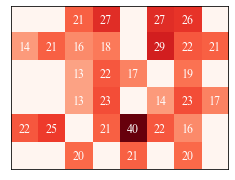

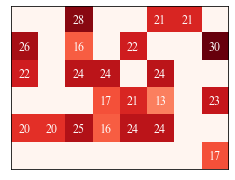

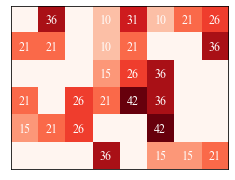

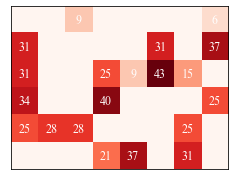

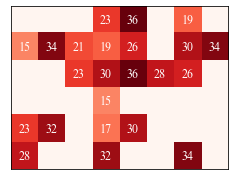

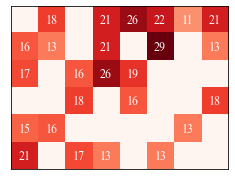

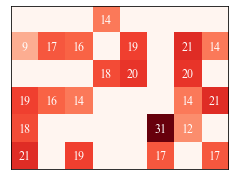

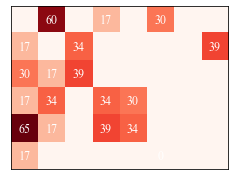

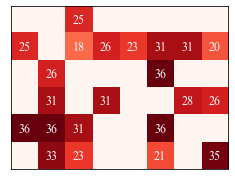

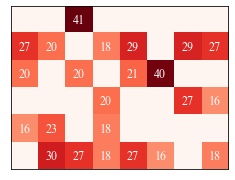

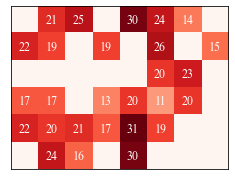

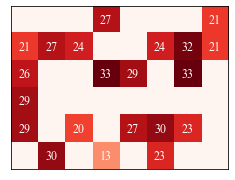

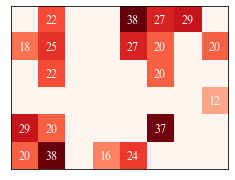

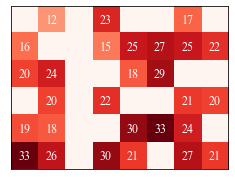

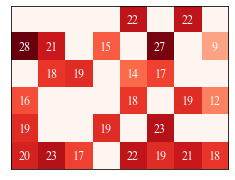

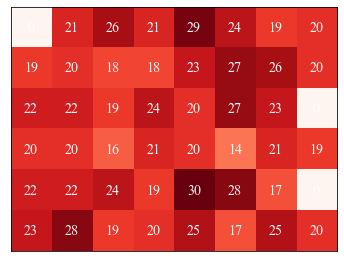

In [44]:
print_individual_error(combine_error_location_details, combined_number_of_one)

In [21]:
# Plot
with_intensity_steps = 3037.035
without_intensity_steps = 9698.27
steps_change = abs(with_intensity_steps - without_intensity_steps)/without_intensity_steps * 100
steps_change

68.68477573835334

In [22]:
# Calculate false positive and false negative rate
without_intensity_true_positive = r1_without_intensity_result['Correct']['Total'] + r2_without_intensity_result['Correct']['Total'] + r3_without_intensity_result['Correct']['Total']
without_intensity_false_positive = r1_without_intensity_result['Incorrect']['Total'] + r2_without_intensity_result['Incorrect']['Total'] + r3_without_intensity_result['Incorrect']['Total']

with_intensity_true_positive = r1_with_intensity_result['Correct']['Total'] + r2_with_intensity_result['Correct']['Total'] + r3_with_intensity_result['Correct']['Total']
with_intensity_false_positive = r1_with_intensity_result['Incorrect']['Total'] + r2_with_intensity_result['Incorrect']['Total'] + r3_with_intensity_result['Incorrect']['Total']


In [23]:
true_positive_increase = (with_intensity_true_positive - without_intensity_true_positive)/without_intensity_true_positive * 100
false_positive_decrease = (without_intensity_false_positive - with_intensity_false_positive)/without_intensity_false_positive * 100

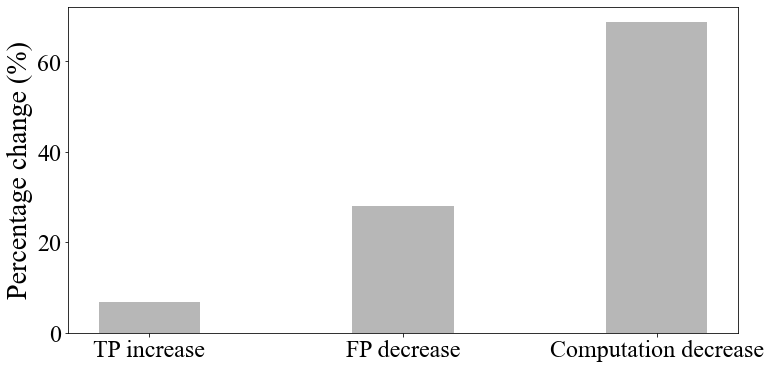

In [62]:
matplotlib.rc('figure', figsize=(12, 6))
plt.rcParams['font.size'] = 24
plt.rcParams["font.family"] = "Times New Roman"
# fig = plt.figure(figsize=(15, 10))
# width=.4
plt.bar(["TP increase", "FP decrease", "Computation decrease"], [true_positive_increase, false_positive_decrease, steps_change], color='#b7b7b7', width=width, align='center')
plt.ylabel("Percentage change (%)", fontsize=28)
plt.savefig("intensity_with_without_metrics.png", dpi=100, bbox_inches="tight")
# plt.legend()
plt.show()

In [25]:
r1_without_intensity_result

,Correct,Incorrect,Total,Average error fixed
Recovered Index,,,,
0,29,23,52,6.275862
1,23,22,45,5.173913
2,3,24,27,6.333333
3,9,13,22,4.666667
4,10,14,24,6.400000
5,30,10,40,4.266667
6,52,15,67,3.865385
7,3,6,9,4.333333
8,18,15,33,6.222222


In [45]:
r1_with_intensity_result

,Correct,Incorrect,Total,Average error fixed
Recovered Index,,,,
0,29,14,43,6.206897
1,27,19,46,5.481481
2,4,9,13,6.750000
3,9,9,18,4.777778
4,11,7,18,6.454545
5,32,6,38,4.281250
6,54,8,62,3.962963
7,5,4,9,5.400000
8,15,8,23,6.200000


In [78]:
true_positive_increase

6.785714285714286

In [79]:
false_positive_decrease

28.08219178082192

In [80]:
steps_change

68.68477573835334